In [1]:
#load our friends
import numpy as np
import math as mt 
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
#define a guassian function to sample
def gaussian(mu,sigma,norm,offset):
    """Returns a gaussian function with the given parameters"""
    return lambda x: norm*np.exp(-(1./2.)*((x-mu)/(sigma))**2)+offset


In [16]:
#define a function to estimate approximate fit parameters form teh data
def initial(data):
    """ Returns the (mu, sigma, norm, offset) estimated from moments in the 1d input array inpData """

    offset=data[0]  #Taking first point as offset of data    
    corrdata=np.ma.masked_less(data-offset,0)   
    #Removing the background for calculating moments of pure gaussian
    #We also ignored(masked) any negative values before measuring moments
    norm=corrdata.max()
    #now compute the mean of the distribution mu=<x>=int(x*f(x))
    total=float(corrdata.sum())
    Xcoords=np.arange(corrdata.shape[0])
    mu=(Xcoords*data).sum()/total
    #finally compute the RMS of the distribution <(x-mu)^2>
    sigma=np.sqrt(np.ma.sum((corrdata*(Xcoords-mu)**2))/total)
    return mu,sigma,norm,offset

#define a function to go from covariance matrix to uncertainty
def getUnc(cov,normerror):
    unc = [] 
    for i in range(len(cov[0])):
        try:
          unc.append(np.absolute(cov[i][i])**0.5)
        except:
          unc.append( 0.00 )
    return unc

#define a fit function
def fitgaussian(data):
    """Returns (height, x, width_x, offset)"""
    #get estimate of the initial parameters
    params = initial(data)    
    #now define the chi-square metric y_obs-y_pred  lambda(pars)=gausian(pars)(x_obs)-y_obs)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    chifunction   = lambda p: np.ravel((gaussian(*p)(*np.indices(data.shape)) - data)/np.sqrt(gaussian(*p)(*np.indices(data.shape))))
    chi2function  = lambda p: np.ravel((gaussian(*p)(*np.indices(data.shape)) - data)**2/gaussian(*p)(*np.indices(data.shape)))
    p,cov,infodict,errmsg, success = optimize.leastsq(chifunction, params,full_output=1)
    unc=getUnc(cov,np.sum(errorfunction(p))/(len(data)-len(p)))
    print "chi2",np.sum(chi2function(p))
    #print cov
    #print unc
    return p,unc

/Users/pharris/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


chi2 46.11692383746474
[100.11616729  19.94609776   9.6873709    7.79930323]


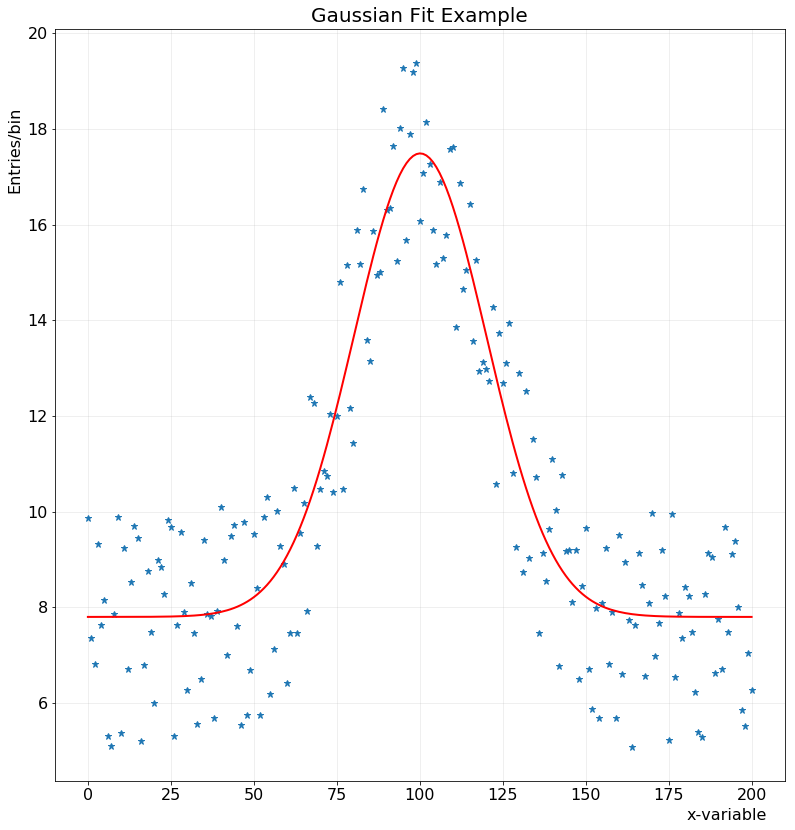

In [17]:
#randomly sample to make data and fit it
%matplotlib inline
plt.style.use('mystyle.mplstyle')
labels_x = "x-variable"
labels_y = "Entries/bin"

Xin = np.mgrid[0:201]
data = gaussian(100., 20., 10., 5)(Xin) + 5*np.random.random(Xin.shape)
plt.plot(data,"*")
params,unc = fitgaussian(data)
fit = gaussian(*params)
YFit=fit(Xin)
print params
label_gau = "Gaussian($\mu={:.1f},\sigma={:.1f}$)".format(params[0],params[1])
plt.xlabel(labels_x,position=(0.92,0.1))
plt.ylabel(labels_y,position=(0.1,0.84))
plt.legend(loc='best')
plt.grid(True, alpha=0.25)
plt.plot(Xin,YFit, color = 'r', label=label_gau)
plt.title("Gaussian Fit Example")
plt.show()

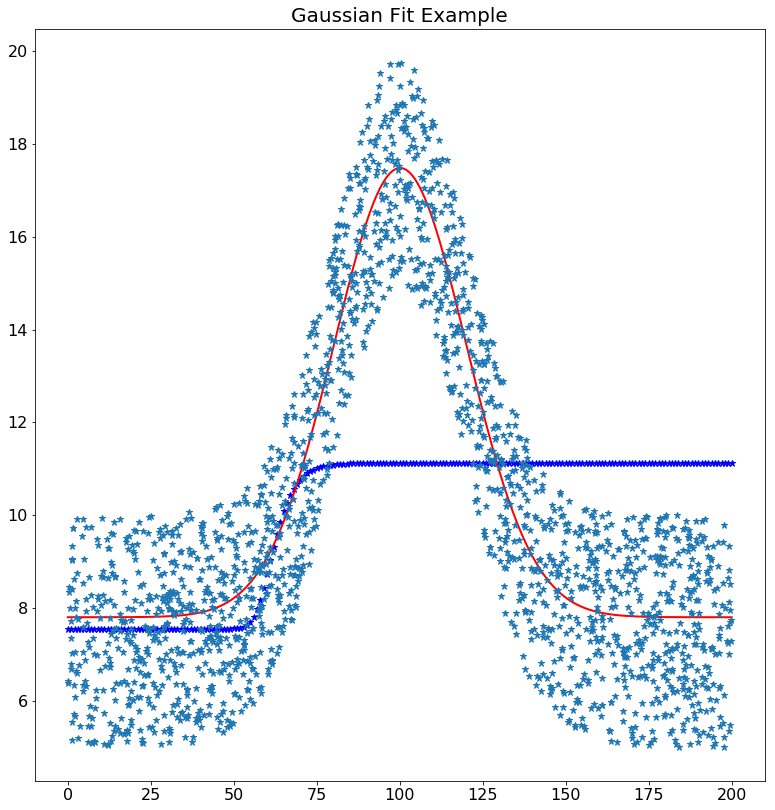

In [29]:
#now lets do a quick neural network
from sklearn.neural_network import MLPRegressor 
mlp = MLPRegressor(hidden_layer_sizes = (10,1), activation='logistic', solver='lbfgs', max_iter=3000)
#make a large dataset to train
XTrain   =200*np.random.random((2000,1)) 
dataTrain= gaussian(100., 20., 10., 5)(XTrain) + 5*np.random.random(XTrain.shape)
dataTmp=dataTrain.reshape(-1,1)
XTmp=XTrain.reshape(-1,1)
mlp.fit(XTmp,dataTmp)
Ymlp=mlp.predict(Xin.reshape(-1,1))
label_mlp = "MLP"
plt.plot(Xin,Ymlp,"*", color = 'b', label=label_mlp)
plt.plot(Xin,YFit, color = 'r', label=label_gau)
#plt.plot(data,"*",label="data")
plt.plot(XTrain,dataTrain,"*",label="data")
plt.title("Gaussian Fit Example")
plt.show()
